In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import utils

import numpy as np
import random

# For working with MATLAB data
import scipy.io as spio

# For plotting
import matplotlib.pyplot as plt

# Set seed
random.seed(1)

# Load data

In [3]:
# Setup the dataset class
# Note: We might want to write out the images instead of reading in a MAT file when our dataset gets bigger. 
# That way we don't have to store the entire dataset at once. 
class gaborDataset(Dataset):
    """Gabor Patches dataset."""

    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (string): Path to the .mat file (includes samplesCrop and labels variables).
            root_dir (string): Directory with the .mat file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # Read the data
        mat = spio.loadmat(mat_file)

        # Assume the mat contains the following:
        imagesTemp = mat['samplesCrop'] # We may want to change this in the future.
        labelsTemp = mat['labels'] 
        self.train = train  # training set or test set
        
        self.transform = transform
        
        nImages = len(labelsTemp)
        
        # Save 50 images for testing
        # Before we do this we have to shuffle the images/labels, since as they're read in
        # all the harmonics are on the top and the non-harmonics on the bottom.
        # Shuffle only operates on the first dimension
        shuffleIndx = np.random.permutation(nImages)
        imagesTemp = imagesTemp[:,:,shuffleIndx]
        labelsTemp = labelsTemp[shuffleIndx]
        
        if self.train:
            self.images = imagesTemp[:,:,0:(nImages-50)]
            self.labels = labelsTemp[0:(nImages-50)]
            self.labels = np.squeeze(self.labels)
        else:
            self.images = imagesTemp[:,:,(nImages-49):nImages]
            self.labels = labelsTemp[(nImages-49):nImages]
            self.labels = np.squeeze(self.labels)
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        

        image = self.images[:,:,idx]
    
        # Easier to work with HxWxC
        image = np.expand_dims(image, axis=2)
        image = T.ToTensor()(image)
        
        sample = {'image': image, 'label': self.labels[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

Number of images: 150
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


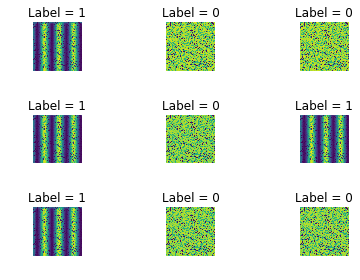

In [4]:
gabor_dataset = gaborDataset('sampleSet.mat',train=True)

fig = plt.figure()
  
print('Number of images: %i' % len(gabor_dataset))

for i in range(0,9):
    
    imSelect = random.randint(0,len(gabor_dataset)-1)
    sample = gabor_dataset[imSelect]
    
    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    ax.set_title("Label = %i" % sample['label'])
    ax.axis('off')
    print(sample['image'].shape)
    plt.imshow(np.squeeze(sample['image']))
   
    

In [5]:
# Use the GPU if it's available

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [6]:
# Calculate mean and std of dataset
# TODO: Do we need to do this?

In [7]:
NUM_TRAIN = 120
NUM_VAL = 30
if((NUM_TRAIN+NUM_VAL) > len(gabor_dataset)):
    print("NUM_TRAIN greater than size of dataset.")


# TL NOTE: Leaving out normalization for now. 
transform = T.Compose([
                T.ToTensor(),
#                 T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

gabor_train = gaborDataset('sampleSet.mat',train=True)
loader_train = DataLoader(gabor_train, batch_size=10, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

gabor_val = gaborDataset('sampleSet.mat',train=True)
loader_val = DataLoader(gabor_val, batch_size=10, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

gabor_test = gaborDataset('sampleSet.mat',train=False)
loader_test = DataLoader(gabor_test, batch_size=10)

# Helper function to show a batch
def show_batch(sample_batched):
    """Show image with label for a batch of samples."""
    images_batch, label_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid[1,:,:])
    plt.title('Batch from dataloader')

Training Set:
0 torch.Size([10, 1, 128, 128])


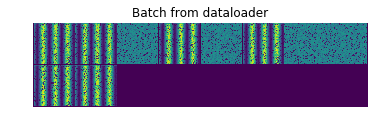

1 torch.Size([10, 1, 128, 128])


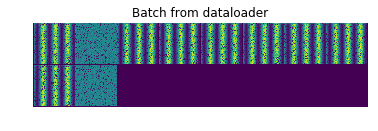

Validation Set:
0 torch.Size([10, 1, 128, 128])


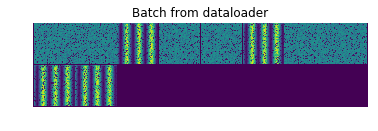

1 torch.Size([10, 1, 128, 128])


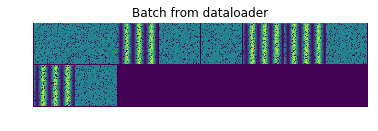

In [8]:
# Show a few batches:
print("Training Set:")
for i_batch, sample_batched in enumerate(loader_train):
    print(i_batch, sample_batched['image'].size())

    # observe first two batches
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        
    if i_batch == 1:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
        
print("Validation Set:")
for i_batch, sample_batched in enumerate(loader_val):
    print(i_batch, sample_batched['image'].size())

    # observe first two batches
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        
    if i_batch == 1:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
        

# Start training
Try a basic 2-layer ConvNet from the homework

In [9]:
import torch.nn.functional as F  # useful stateless functions

def train_part34(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        
        for t, sample_batched in enumerate(loader_train): 

            x, y = sample_batched['image'], sample_batched['label']      
            
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            y = np.squeeze(y)
            
            scores = model(x)
            
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [10]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for sample_batched in loader:
            x, y = sample_batched['image'], sample_batched['label'] 

            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [11]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

channel_1 = 16
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None
       
model = nn.Sequential(
#     nn.Conv2d(1,channel_1,5,padding=2),
#     nn.ReLU(),
#     nn.Conv2d(channel_1,channel_2,3,padding=1),
#     nn.ReLU(),
    Flatten(),
#     nn.Linear(channel_2*128*128, 1)  
    nn.Linear(1*128*128, 2)  
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer,epochs=2)

Iteration 0, loss = 16.0982
Checking accuracy on validation set
Got 20 / 30 correct (66.67)

Iteration 0, loss = 0.0000
Checking accuracy on validation set
Got 30 / 30 correct (100.00)



In [12]:
best_model = model
check_accuracy_part34(loader_test, best_model)

Checking accuracy on test set
Got 49 / 49 correct (100.00)


In [16]:
# Visualize weights
# From: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb

def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    '''
    savetensor: save tensor
        @filename: file name
        @ch: visualization channel 
        @allkernels: visualization all tensores
    '''    

    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )

torch.Size([2, 16384])
torch.Size([2, 1, 128, 128])


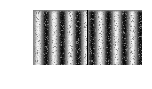

In [23]:

for layer in best_model.modules():
   if isinstance(layer, nn.Linear):                  
        kernel = layer.weight.clone()
        print(kernel.shape)
        kernel = kernel.view((2,1,128,128))
        print(kernel.shape)
        break

vistensor(kernel.data, ch=0, allkernels=False)
# savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()